In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from datetime import datetime # needed this to parse my sql alchemy string date to python date

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# use inspector to look at the columns in table
inspector = inspect(engine)
columns = inspector.get_columns('Measurement')
for column in columns:
    print(column["name"], column["type"])
print('-------------')
columns = inspector.get_columns('Station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
-------------
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [11]:
# get last date from table
last_date = session.query(Measurement).order_by(Measurement.date.desc()).first().date

# calc start date 1 year (365 days) prior to last date
start_date = datetime.strptime(last_date, '%Y-%m-%d') - dt.timedelta(days=366)
start_date


datetime.datetime(2016, 8, 22, 0, 0)

In [12]:
# query to pull precipitation scores by date
query = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= start_date)

#save query into a dataframe 
df = pd.read_sql_query(query.statement, engine)

# set index to date
df.set_index('date', inplace=True)

# sort by date (index)
df.sort_index(inplace=True)

df.head()

,prcp
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15


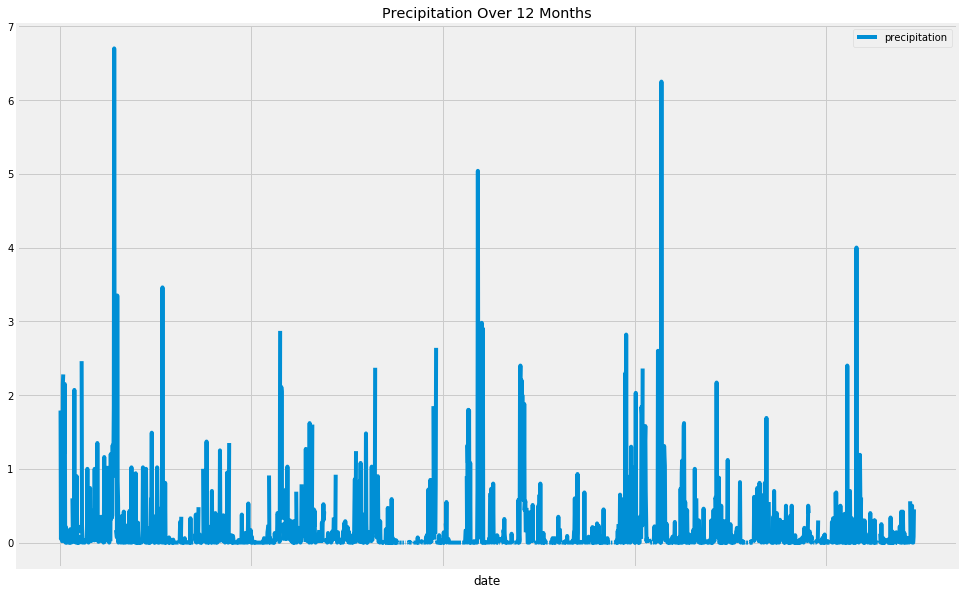

In [13]:
# let's plot!
fig, ax = plt.subplots()
df.plot(ax=ax, figsize=(15,10), title='Precipitation Over 12 Months')
ax.legend(['precipitation'])
plt.savefig('Images/precipitation')
plt.show()

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [15]:
# query to find how many stations are in
print(f'There are {session.query(Station).count()} stations in the dataset')

There are 9 stations in the dataset


In [16]:
# query to find # of measurements by station in ordered in descending order by total 
session.query(Measurement.station, func.count(Measurement.id)) \
    .group_by(Measurement.station) \
    .order_by(func.count(Measurement.id).desc()) \
    .all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# get the station id of the station with the most measurements
top_station = session.query(Measurement.station,func.count(Measurement.id)) \
    .group_by(Measurement.station) \
    .order_by(func.count(Measurement.id).desc()) \
    .first()

print(f'Station Id {top_station.station} is the station with the most measurements')

Station Id USC00519281 is the station with the most measurements


In [18]:
# find the lowest temp, hightest temp and avg temp recorded for most active station
session.query(Measurement.station, 
              func.min(Measurement.tobs).label('min_tobs'), \
              func.max(Measurement.tobs).label('max_tobs'), \
              func.avg(Measurement.tobs).label('avg_tobs')) \
    .filter(Measurement.station == top_station.station) \
    .all()

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

In [19]:
# get 12 months of temperature observation data (tabos) data for the most active station
query = session.query(Measurement.tobs) \
    .filter(Measurement.date >= start_date) \
    .filter(Measurement.station == top_station.station)

df_tobs = pd.read_sql_query(query.statement, engine)

df_tobs.head()

,tobs
0,77.0
1,77.0
2,80.0
3,80.0
4,75.0


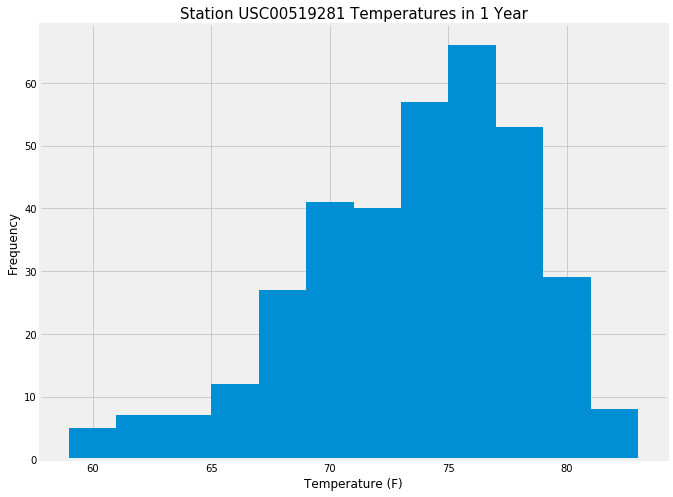

In [20]:
# plot histogram
ax = df_tobs.hist(column='tobs', bins=12, figsize=(10,8))
plt.title(f'Station {top_station.station} Temperatures in 1 Year',fontsize=15)
plt.xlabel("Temperature (F)",fontsize=12)
plt.ylabel("Frequency",fontsize=12)
plt.savefig('Images/temperatuure')
plt.show()


## Temperature Analysis I

In [21]:
# get the avg temperatures across all stations and all years for months of June and Dec
avg_june = session.query(func.avg(Measurement.tobs)) \
    .filter(func.strftime("%m", Measurement.date) == '06') \
    .group_by(Measurement.station) \
    .all()
avg_june

avg_dec = session.query(func.avg(Measurement.tobs)) \
    .filter(func.strftime("%m", Measurement.date) == '12') \
    .group_by(Measurement.station) \
    .all()
avg_dec
# print(type(avg_june))
# np.array(avg_june)
# print(f'Avg June Temp = {avg_june} and Avg Dec Temp = {avg_dec}')

[(69.6842105263158),
 (71.06944444444444),
 (73.2247191011236),
 (69.29126213592232),
 (71.8348623853211),
 (72.42105263157895),
 (69.90322580645162),
 (71.10952380952381),
 (72.43333333333334)]

In [22]:
avg_june

[(74.13939393939394),
 (74.05084745762711),
 (76.00537634408602),
 (71.9372197309417),
 (76.6554054054054),
 (73.39473684210526),
 (73.27118644067797),
 (77.55932203389831),
 (76.66810344827586)]

### Paired T-Test - Avg June Temps vs Avg Dec Temps
A paired T-Test is performed as the data comes from the same samples (same weather stations

In [23]:
stats.ttest_rel(np.array(avg_june), np.array(avg_dec))

Ttest_relResult(statistic=array([6.95696617]), pvalue=array([0.00011759]))

When attempting to find if Hawaii has mild weather all year, we tried to answer the following question: Is there a meaningful difference between the temperature in June and December? To answer the that question, I performed a paired T-Test for the average temperatures for each station in the months of June and December. A paired T-Test was performed as the data comes from the same sample (same weather stations). The null hypothesis? The temperature in Hawaii is the same in June and in December.

Spoiler: the paired T-Test resulted in a P-value of 0.00011759 indicating that there IS statistical difference in the temperatures between June and December. We must reject the null hypothesis that June and December have the same temperatures. 

## Temperature Analysis II

In [24]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [25]:
# lets plan the trip for over my birthday. let's check the temps from a prevous year!
print(calc_temps('2017-02-20', '2017-03-02'))

[(61.0, 70.07142857142857, 77.0)]


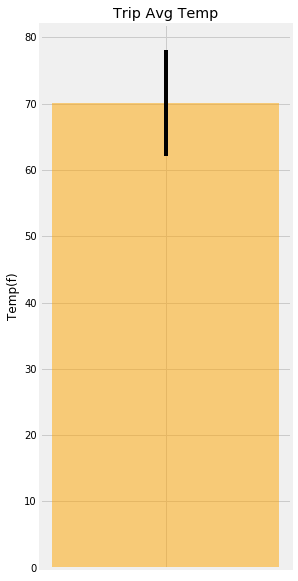

In [26]:
# for the temp calculation let's plot a bar chart
temps = calc_temps('2017-02-20', '2017-03-02')[0]
x_axis = ['']
values =[temps[1]]

# create array of min and max temps so we can calculate std error
min_max = [temps[0], temps[2]]
std_error = stats.sem(min_max)

# plot the avg temp
fig, ax = plt.subplots(figsize=(4,10))
plt.bar(x_axis, values, yerr=std_error, color='orange',alpha=0.5)
plt.title("Trip Avg Temp")
plt.ylabel("Temp(f)")
plt.savefig('Images/trip_avg_temperature')
plt.show()


In [27]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
sel = [Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation, \
       func.sum(Measurement.prcp)]
rainfall = session.query(*sel) \
    .filter(Measurement.station == Station.station) \
    .filter(Measurement.date >= '2017-02-20') \
    .filter(Measurement.date <= '2017-03-02') \
    .group_by(Measurement.station) \
    .order_by(func.sum(Measurement.prcp).desc()) \
    .all()
rainfall

[('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  4.1),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 3.87),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  3.67),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 3.01),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  2.2),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 2.08),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  1.27)]